In [1]:
# RAW Performance Testing Setup and Tips

print("🎯 RAW Performance Testing Tips:")
print("- RAW operations are typically fast but can be affected by data size and network latency")
print("- Batch operations are generally more efficient than individual operations")
print("- Consider using cursors for retrieving large datasets")
print("- RAW tables have limits on row size and total table size")
print("- Monitor your CDF RAW storage quota during testing")

print("\n📊 Test Categories:")
print("- Table creation and management operations")
print("- Single vs batch row insertion performance")
print("- Row retrieval patterns (filters, cursors, limits)")
print("- Row update operations")
print("- Table deletion and cleanup")

print("\n📝 Next Steps:")
print("- Analyze performance patterns for your specific use case")
print("- Compare single vs batch operations")
print("- Test with realistic data volumes")
print("- Consider indexing strategies for better query performance")
print("- Plan for error handling and retry logic in production")

print("\n⚠️ Important Notes:")
print("- Remember to run cleanup at the end to avoid quota usage")
print("- Be aware of CDF RAW storage limits and costs")
print("- Test in a dedicated environment when possible")
print("- Large datasets may require pagination strategies")


🎯 RAW Performance Testing Tips:
- RAW operations are typically fast but can be affected by data size and network latency
- Batch operations are generally more efficient than individual operations
- Consider using cursors for retrieving large datasets
- RAW tables have limits on row size and total table size
- Monitor your CDF RAW storage quota during testing

📊 Test Categories:
- Table creation and management operations
- Single vs batch row insertion performance
- Row retrieval patterns (filters, cursors, limits)
- Row update operations
- Table deletion and cleanup

📝 Next Steps:
- Analyze performance patterns for your specific use case
- Compare single vs batch operations
- Test with realistic data volumes
- Consider indexing strategies for better query performance
- Plan for error handling and retry logic in production

⚠️ Important Notes:
- Remember to run cleanup at the end to avoid quota usage
- Be aware of CDF RAW storage limits and costs
- Test in a dedicated environment when p

In [2]:
# Import required libraries
import sys
sys.path.append('../..')

from utilities.performance_utils import PerformanceTracker, benchmark_operation, generate_test_data
from configs.cdf_config import config
import pandas as pd
import numpy as np
import time
import json
import random
import string
from datetime import datetime, timedelta
from concurrent.futures import ThreadPoolExecutor, as_completed

try:
    from cognite.client import CogniteClient
    from cognite.client.data_classes import Row
    CDF_IMPORTS_AVAILABLE = True
    print("✅ Successfully imported CDF SDK classes")
    print("   RAW API available for performance testing")
except ImportError as e:
    print(f"❌ CDF SDK imports not available: {e}")
    print("Please install cognite-sdk: pip install cognite-sdk --upgrade")
    CDF_IMPORTS_AVAILABLE = False

# For plotting (optional)
try:
    import matplotlib.pyplot as plt
    plt.style.use('default')
    PLOTTING_AVAILABLE = True
    print("✅ Matplotlib available for plotting")
except ImportError:
    print("⚠️  Matplotlib not available. Install with: pip install matplotlib")
    PLOTTING_AVAILABLE = False


✅ Successfully imported CDF SDK classes
   RAW API available for performance testing
✅ Matplotlib available for plotting


In [3]:
# Initialize CDF client using the client setup utility
from utilities.client_setup import get_client, test_connection

# Get the configured CDF client
client = get_client()

# RAW performance testing configuration
DATABASE_NAME = "raw_performance_test"
TEST_TABLES = ["performance_table_1", "performance_table_2", "batch_test_table"]

if client is None:
    print("Failed to create CDF client. Please check your .env file.")
    print("Run: python ../../test_connection.py to test your connection")
else:
    # Test the connection
    if test_connection():
        print("Ready to run RAW performance tests!")
        print(f"SDK version: {client.version if hasattr(client, 'version') else 'Available'}")
    else:
        print("Connection test failed. Please check your credentials.")


✓ Successfully connected to CDF project: templates-dev
🔍 Testing CDF connection...
📋 Current .env configuration:
----------------------------------------
  CDF_PROJECT: templates-dev
  CDF_CLUSTER: aws-dub-dev
  CDF_BASE_URL: https://aws-dub-dev.cognitedata.com
  DEFAULT_BATCH_SIZE: 1000
  DEFAULT_ITERATIONS: 10
  LOG_LEVEL: INFO
  CDF_CLIENT_ID: 8242****************************a218
  CDF_CLIENT_SECRET: KN98********************************fb.o
  CDF_TENANT_ID: b897****************************1a62
----------------------------------------
✓ Configuration is valid
✓ Successfully connected to CDF project: templates-dev
✓ Connection successful!
  Project: templates-dev


C:\Users\JanIngeBergseth\AppData\Roaming\Python\Python313\site-packages\ipykernel\ipkernel.py:766: UserWarning: You are using version='7.76.1' of the SDK, however version='7.77.1' is available. To suppress this warning, either upgrade or do the following:
>>> from cognite.client.config import global_config
>>> global_config.disable_pypi_version_check = True
  _threading_Thread_run(self)


  Token is valid and accessible
Ready to run RAW performance tests!
SDK version: 7.76.1


In [4]:
# Verify client and imports are available before proceeding
if client is None:
    raise RuntimeError(
        "CDF client is not available. Cannot proceed with RAW performance tests.\n"
        "Please ensure your .env file is properly configured."
    )

if not CDF_IMPORTS_AVAILABLE:
    raise RuntimeError(
        "CDF SDK imports are not available. Cannot proceed with RAW tests.\n"
        "Please install cognite-sdk: pip install cognite-sdk --upgrade"
    )

print("🚀 Client verified. Initializing performance tracker...")

# Initialize performance tracker for RAW operations
tracker = PerformanceTracker("raw_operations")

print("✅ Ready to run RAW performance tests!")

# Helper functions for test data generation
def generate_random_string(length=10):
    """Generate a random string of specified length."""
    return ''.join(random.choices(string.ascii_letters + string.digits, k=length))

def generate_test_row(key=None, additional_columns=None):
    """Generate a test row with random data."""
    if key is None:
        key = f"test_key_{int(time.time() * 1000)}_{generate_random_string(5)}"
    
    base_data = {
        "timestamp": datetime.now().isoformat(),
        "value": random.uniform(0, 1000),
        "status": random.choice(["active", "inactive", "pending"]),
        "description": f"Test data generated at {datetime.now()}"
    }
    
    # Add additional columns if specified
    if additional_columns:
        base_data.update(additional_columns)
    
    return Row(key=key, columns=base_data)

def generate_test_rows(count, table_prefix="test"):
    """Generate multiple test rows."""
    rows = []
    for i in range(count):
        key = f"{table_prefix}_row_{i}_{int(time.time() * 1000)}"
        row = generate_test_row(
            key=key,
            additional_columns={"row_index": i, "batch_id": f"batch_{int(time.time())}"}
        )
        rows.append(row)
    return rows

def cleanup_tables():
    """Clean up test tables (helper function)."""
    if client is None:
        return False
    
    try:
        # Delete tables if they exist
        existing_tables = client.raw.tables.list(DATABASE_NAME)
        table_names = [table.name for table in existing_tables]
        
        for table_name in TEST_TABLES:
            if table_name in table_names:
                client.raw.tables.delete(DATABASE_NAME, table_name)
                print(f"    Deleted table: {table_name}")
        
        return True
    except Exception as e:
        print(f"Warning: Could not clean up tables: {e}")
        return False

print("🎯 Test data generation helpers ready!")
print("📁 Available helper functions:")
print("  - generate_random_string(length)")
print("  - generate_test_row(key, additional_columns)")
print("  - generate_test_rows(count, table_prefix)")
print("  - cleanup_tables()")
print(f"📊 Test database: {DATABASE_NAME}")
print(f"📋 Test tables: {TEST_TABLES}")


🚀 Client verified. Initializing performance tracker...
✅ Ready to run RAW performance tests!
🎯 Test data generation helpers ready!
📁 Available helper functions:
  - generate_random_string(length)
  - generate_test_row(key, additional_columns)
  - generate_test_rows(count, table_prefix)
  - cleanup_tables()
📊 Test database: raw_performance_test
📋 Test tables: ['performance_table_1', 'performance_table_2', 'batch_test_table']


In [5]:
# Test 1: RAW Table Creation and Management Performance
def test_table_operations():
    """Test performance of RAW table creation and management operations."""
    
    if client is None:
        print("❌ Cannot run test: Client not initialized.")
        return None
    
    print("📊 Testing RAW table operations performance...")
    
    results = {}
    
    # Test 1: Database creation (if it doesn't exist)
    print("  Testing database operations...")
    
    def create_database():
        # Check if database exists, create if it doesn't
        if client is None:
            raise RuntimeError("Client not initialized")
        
        # Check if database exists by listing databases
        databases = client.raw.databases.list()
        db_names = [db.name for db in databases]
        
        if DATABASE_NAME in db_names:
            return "exists"
        else:
            # Database doesn't exist, create it
            client.raw.databases.create(DATABASE_NAME)
            return "created"
    
    try:
        benchmark_results = benchmark_operation(create_database, iterations=3, warmup=1)
        results["database_operation"] = benchmark_results
        print(f"    Database operation time: {benchmark_results['mean_time']:.4f}s")
    except Exception as e:
        print(f"    ❌ Error in database operations: {e}")
        results["database_operation"] = None
    
    # Test 2: Table creation
    print("  Testing table creation...")
    
    def create_table():
        if client is None:
            raise RuntimeError("Client not initialized")
        
        table_name = f"perf_test_table_{int(time.time() * 1000)}"
        client.raw.tables.create(DATABASE_NAME, table_name)
        return table_name
    
    try:
        benchmark_results = benchmark_operation(create_table, iterations=5, warmup=1)
        results["table_creation"] = benchmark_results
        print(f"    Mean table creation time: {benchmark_results['mean_time']:.4f}s")
        print(f"    Tables created per second: {benchmark_results['operations_per_second']:.2f}")
    except Exception as e:
        print(f"    ❌ Error in table creation: {e}")
        results["table_creation"] = None
    
    # Test 3: Table listing
    print("  Testing table listing...")
    
    def list_tables():
        if client is None:
            raise RuntimeError("Client not initialized")
        
        tables = client.raw.tables.list(DATABASE_NAME)
        return len(tables)
    
    try:
        benchmark_results = benchmark_operation(list_tables, iterations=10, warmup=2)
        results["table_listing"] = benchmark_results
        print(f"    Mean table listing time: {benchmark_results['mean_time']:.4f}s")
        
        # Get the number of tables
        if benchmark_results.get('return_value'):
            print(f"    Number of tables found: {benchmark_results['return_value']}")
    except Exception as e:
        print(f"    ❌ Error in table listing: {e}")
        results["table_listing"] = None
    
    # Test 4: Table deletion (clean up test tables)
    print("  Testing table deletion...")
    
    def delete_table():
        if client is None:
            raise RuntimeError("Client not initialized")
        
        # Create a table to delete
        table_name = f"temp_delete_test_{int(time.time() * 1000)}"
        client.raw.tables.create(DATABASE_NAME, table_name)
        
        # Delete it
        client.raw.tables.delete(DATABASE_NAME, table_name)
        return table_name
    
    try:
        benchmark_results = benchmark_operation(delete_table, iterations=5, warmup=1)
        results["table_deletion"] = benchmark_results
        print(f"    Mean table deletion time: {benchmark_results['mean_time']:.4f}s")
        print(f"    Tables deleted per second: {benchmark_results['operations_per_second']:.2f}")
    except Exception as e:
        print(f"    ❌ Error in table deletion: {e}")
        results["table_deletion"] = None
    
    return results

# Run table operations test
table_results = test_table_operations()


📊 Testing RAW table operations performance...
  Testing database operations...
    Database operation time: 0.0612s
  Testing table creation...
    Mean table creation time: 0.0665s
    Tables created per second: 15.03
  Testing table listing...
    Mean table listing time: 0.0619s
  Testing table deletion...
    Mean table deletion time: 0.1399s
    Tables deleted per second: 7.15


In [6]:
# Test 2: RAW Row Insertion Performance (Single vs Batch)
def test_row_insertion_performance():
    """Test performance of single row vs batch row insertion."""
    
    if client is None:
        print("❌ Cannot run test: Client not initialized.")
        return None
    
    print("📤 Testing RAW row insertion performance...")
    
    results = {}
    table_name = TEST_TABLES[0]  # Use first test table
    
    # Ensure table exists
    try:
        client.raw.tables.create(DATABASE_NAME, table_name)
        print(f"    Created table: {table_name}")
    except Exception as e:
        print(f"    Table {table_name} might already exist: {e}")
    
    # Test 1: Single row insertion
    print("  Testing single row insertion...")
    
    def insert_single_row():
        if client is None:
            raise RuntimeError("Client not initialized")
        
        row = generate_test_row()
        client.raw.rows.insert(DATABASE_NAME, table_name, row)
        return row.key
    
    try:
        benchmark_results = benchmark_operation(insert_single_row, iterations=20, warmup=3)
        results["single_row_insertion"] = benchmark_results
        print(f"    Mean single row insertion time: {benchmark_results['mean_time']:.4f}s")
        print(f"    Single rows per second: {benchmark_results['operations_per_second']:.2f}")
    except Exception as e:
        print(f"    ❌ Error in single row insertion: {e}")
        results["single_row_insertion"] = None
    
    # Test 2: Small batch insertion (10 rows)
    print("  Testing small batch insertion (10 rows)...")
    
    def insert_small_batch():
        if client is None:
            raise RuntimeError("Client not initialized")
        
        rows = generate_test_rows(10, "small_batch")
        client.raw.rows.insert(DATABASE_NAME, table_name, rows)
        return len(rows)
    
    try:
        benchmark_results = benchmark_operation(insert_small_batch, iterations=10, warmup=2)
        results["small_batch_insertion"] = benchmark_results
        print(f"    Mean small batch insertion time: {benchmark_results['mean_time']:.4f}s")
        print(f"    Small batches per second: {benchmark_results['operations_per_second']:.2f}")
        print(f"    Rows per second (small batch): {benchmark_results['operations_per_second'] * 10:.2f}")
    except Exception as e:
        print(f"    ❌ Error in small batch insertion: {e}")
        results["small_batch_insertion"] = None
    
    # Test 3: Medium batch insertion (100 rows)
    print("  Testing medium batch insertion (100 rows)...")
    
    def insert_medium_batch():
        if client is None:
            raise RuntimeError("Client not initialized")
        
        rows = generate_test_rows(100, "medium_batch")
        client.raw.rows.insert(DATABASE_NAME, table_name, rows)
        return len(rows)
    
    try:
        benchmark_results = benchmark_operation(insert_medium_batch, iterations=5, warmup=1)
        results["medium_batch_insertion"] = benchmark_results
        print(f"    Mean medium batch insertion time: {benchmark_results['mean_time']:.4f}s")
        print(f"    Medium batches per second: {benchmark_results['operations_per_second']:.2f}")
        print(f"    Rows per second (medium batch): {benchmark_results['operations_per_second'] * 100:.2f}")
    except Exception as e:
        print(f"    ❌ Error in medium batch insertion: {e}")
        results["medium_batch_insertion"] = None
    
    # Test 4: Large batch insertion (1000 rows)
    print("  Testing large batch insertion (1000 rows)...")
    
    def insert_large_batch():
        if client is None:
            raise RuntimeError("Client not initialized")
        
        rows = generate_test_rows(1000, "large_batch")
        client.raw.rows.insert(DATABASE_NAME, table_name, rows)
        return len(rows)
    
    try:
        benchmark_results = benchmark_operation(insert_large_batch, iterations=3, warmup=1)
        results["large_batch_insertion"] = benchmark_results
        print(f"    Mean large batch insertion time: {benchmark_results['mean_time']:.4f}s")
        print(f"    Large batches per second: {benchmark_results['operations_per_second']:.2f}")
        print(f"    Rows per second (large batch): {benchmark_results['operations_per_second'] * 1000:.2f}")
    except Exception as e:
        print(f"    ❌ Error in large batch insertion: {e}")
        results["large_batch_insertion"] = None
    
    return results

# Run row insertion performance test
insertion_results = test_row_insertion_performance()


📤 Testing RAW row insertion performance...
    Created table: performance_table_1
  Testing single row insertion...
    Mean single row insertion time: 0.0781s
    Single rows per second: 12.81
  Testing small batch insertion (10 rows)...
    Mean small batch insertion time: 0.0824s
    Small batches per second: 12.14
    Rows per second (small batch): 121.43
  Testing medium batch insertion (100 rows)...
    Mean medium batch insertion time: 0.1238s
    Medium batches per second: 8.08
    Rows per second (medium batch): 807.88
  Testing large batch insertion (1000 rows)...
    Mean large batch insertion time: 0.5571s
    Large batches per second: 1.80
    Rows per second (large batch): 1795.12


In [7]:
# Test 3: RAW Row Retrieval Performance
def test_row_retrieval_performance():
    """Test performance of various row retrieval patterns."""
    
    if client is None:
        print("❌ Cannot run test: Client not initialized.")
        return None
    
    print("📥 Testing RAW row retrieval performance...")
    
    results = {}
    table_name = TEST_TABLES[1]  # Use second test table
    
    # Ensure table exists and has test data
    try:
        client.raw.tables.create(DATABASE_NAME, table_name)
        print(f"    Created table: {table_name}")
        
        # Insert test data for retrieval tests
        test_rows = generate_test_rows(500, "retrieval_test")
        client.raw.rows.insert(DATABASE_NAME, table_name, test_rows)
        print(f"    Inserted {len(test_rows)} test rows for retrieval tests")
        
    except Exception as e:
        print(f"    Setup warning: {e}")
    
    # Test 1: List all rows (no filters)
    print("  Testing list all rows...")
    
    def list_all_rows():
        if client is None:
            raise RuntimeError("Client not initialized")
        
        rows = client.raw.rows.list(DATABASE_NAME, table_name, limit=None)
        return len(rows)
    
    try:
        benchmark_results = benchmark_operation(list_all_rows, iterations=5, warmup=1)
        results["list_all_rows"] = benchmark_results
        print(f"    Mean list all rows time: {benchmark_results['mean_time']:.4f}s")
        if benchmark_results.get('return_value'):
            print(f"    Rows retrieved: {benchmark_results['return_value']}")
    except Exception as e:
        print(f"    ❌ Error in list all rows: {e}")
        results["list_all_rows"] = None
    
    # Test 2: List rows with limit
    print("  Testing list rows with limit (100)...")
    
    def list_limited_rows():
        if client is None:
            raise RuntimeError("Client not initialized")
        
        rows = client.raw.rows.list(DATABASE_NAME, table_name, limit=100)
        return len(rows)
    
    try:
        benchmark_results = benchmark_operation(list_limited_rows, iterations=10, warmup=2)
        results["list_limited_rows"] = benchmark_results
        print(f"    Mean limited list time: {benchmark_results['mean_time']:.4f}s")
        print(f"    Limited queries per second: {benchmark_results['operations_per_second']:.2f}")
    except Exception as e:
        print(f"    ❌ Error in limited list: {e}")
        results["list_limited_rows"] = None
    
    # Test 3: Retrieve specific row by key
    print("  Testing retrieve specific row by key...")
    
    def retrieve_specific_row():
        if client is None:
            raise RuntimeError("Client not initialized")
        
        # Get a known key first
        rows = client.raw.rows.list(DATABASE_NAME, table_name, limit=1)
        if not rows:
            raise ValueError("No rows available for retrieval test")
        
        key = rows[0].key
        if key is None:
            raise ValueError("Row key is None")
        
        row = client.raw.rows.retrieve(DATABASE_NAME, table_name, key)
        return key if row else None
    
    try:
        benchmark_results = benchmark_operation(retrieve_specific_row, iterations=15, warmup=3)
        results["retrieve_specific_row"] = benchmark_results
        print(f"    Mean specific retrieval time: {benchmark_results['mean_time']:.4f}s")
        print(f"    Specific retrievals per second: {benchmark_results['operations_per_second']:.2f}")
    except Exception as e:
        print(f"    ❌ Error in specific retrieval: {e}")
        results["retrieve_specific_row"] = None
    
    # Test 4: Retrieve multiple rows by individual calls
    print("  Testing retrieve multiple rows (5 individual calls)...")
    
    def retrieve_multiple_rows():
        if client is None:
            raise RuntimeError("Client not initialized")
        
        # Get some known keys
        rows = client.raw.rows.list(DATABASE_NAME, table_name, limit=10)
        if len(rows) < 5:
            raise ValueError("Not enough rows for multiple retrieval test")
        
        keys = [row.key for row in rows[:5] if row.key is not None]
        retrieved_count = 0
        
        for key in keys:
            row = client.raw.rows.retrieve(DATABASE_NAME, table_name, key)
            if row:
                retrieved_count += 1
        
        return retrieved_count
    
    try:
        benchmark_results = benchmark_operation(retrieve_multiple_rows, iterations=10, warmup=2)
        results["retrieve_multiple_rows"] = benchmark_results
        print(f"    Mean multiple retrieval time: {benchmark_results['mean_time']:.4f}s")
        print(f"    Multiple retrievals per second: {benchmark_results['operations_per_second']:.2f}")
    except Exception as e:
        print(f"    ❌ Error in multiple retrieval: {e}")
        results["retrieve_multiple_rows"] = None
    
    # Test 5: List rows in chunks (simulated pagination)
    print("  Testing chunked row listing...")
    
    def test_chunked_listing():
        if client is None:
            raise RuntimeError("Client not initialized")
        
        total_rows = 0
        
        # Get first chunk
        first_chunk = client.raw.rows.list(DATABASE_NAME, table_name, limit=50)
        total_rows += len(first_chunk)
        
        # Get second chunk
        second_chunk = client.raw.rows.list(DATABASE_NAME, table_name, limit=50)
        total_rows += len(second_chunk)
        
        return total_rows
    
    try:
        benchmark_results = benchmark_operation(test_chunked_listing, iterations=5, warmup=1)
        results["chunked_listing"] = benchmark_results
        print(f"    Mean chunked listing time: {benchmark_results['mean_time']:.4f}s")
        if benchmark_results.get('return_value'):
            print(f"    Rows retrieved via chunked listing: {benchmark_results['return_value']}")
    except Exception as e:
        print(f"    ❌ Error in chunked listing: {e}")
        results["chunked_listing"] = None
    
    return results

# Run row retrieval performance test
retrieval_results = test_row_retrieval_performance()


📥 Testing RAW row retrieval performance...
    Created table: performance_table_2
    Inserted 500 test rows for retrieval tests
  Testing list all rows...
    Mean list all rows time: 0.4357s
  Testing list rows with limit (100)...
    Mean limited list time: 0.0810s
    Limited queries per second: 12.35
  Testing retrieve specific row by key...
    Mean specific retrieval time: 0.1812s
    Specific retrievals per second: 5.52
  Testing retrieve multiple rows (5 individual calls)...
    Mean multiple retrieval time: 0.4192s
    Multiple retrievals per second: 2.39
  Testing chunked row listing...
    Mean chunked listing time: 0.1615s


In [8]:
# Test 4: RAW Row Update Performance
def test_row_update_performance():
    """Test performance of row updates (upserts)."""
    
    if client is None:
        print("❌ Cannot run test: Client not initialized.")
        return None
    
    print("🔄 Testing RAW row update performance...")
    
    results = {}
    table_name = TEST_TABLES[2]  # Use third test table
    
    # Ensure table exists and has test data
    try:
        client.raw.tables.create(DATABASE_NAME, table_name)
        print(f"    Created table: {table_name}")
        
        # Insert initial test data for update tests
        initial_rows = generate_test_rows(100, "update_test")
        client.raw.rows.insert(DATABASE_NAME, table_name, initial_rows)
        print(f"    Inserted {len(initial_rows)} initial rows for update tests")
        
    except Exception as e:
        print(f"    Setup warning: {e}")
    
    # Test 1: Single row update (upsert)
    print("  Testing single row update...")
    
    def update_single_row():
        if client is None:
            raise RuntimeError("Client not initialized")
        
        # Get a known key first
        rows = client.raw.rows.list(DATABASE_NAME, table_name, limit=1)
        if not rows or rows[0].key is None:
            raise ValueError("No rows available for update test")
        
        key = rows[0].key
        updated_row = generate_test_row(
            key=key,
            additional_columns={
                "updated_at": datetime.now().isoformat(),
                "update_count": random.randint(1, 100),
                "status": "updated"
            }
        )
        
        client.raw.rows.insert(DATABASE_NAME, table_name, updated_row)  # insert acts as upsert
        return key
    
    try:
        benchmark_results = benchmark_operation(update_single_row, iterations=15, warmup=3)
        results["single_row_update"] = benchmark_results
        print(f"    Mean single row update time: {benchmark_results['mean_time']:.4f}s")
        print(f"    Single row updates per second: {benchmark_results['operations_per_second']:.2f}")
    except Exception as e:
        print(f"    ❌ Error in single row update: {e}")
        results["single_row_update"] = None
    
    # Test 2: Batch update (multiple rows)
    print("  Testing batch row updates (10 rows)...")
    
    def update_batch_rows():
        if client is None:
            raise RuntimeError("Client not initialized")
        
        # Get some known keys
        rows = client.raw.rows.list(DATABASE_NAME, table_name, limit=10)
        if len(rows) < 10:
            raise ValueError("Not enough rows for batch update test")
        
        updated_rows = []
        for row in rows[:10]:
            if row.key is not None:
                updated_row = generate_test_row(
                    key=row.key,
                    additional_columns={
                        "batch_updated_at": datetime.now().isoformat(),
                        "batch_update_id": f"batch_{int(time.time())}",
                        "status": "batch_updated"
                    }
                )
                updated_rows.append(updated_row)
        
        if updated_rows:
            client.raw.rows.insert(DATABASE_NAME, table_name, updated_rows)
        
        return len(updated_rows)
    
    try:
        benchmark_results = benchmark_operation(update_batch_rows, iterations=10, warmup=2)
        results["batch_row_update"] = benchmark_results
        print(f"    Mean batch update time: {benchmark_results['mean_time']:.4f}s")
        print(f"    Batch updates per second: {benchmark_results['operations_per_second']:.2f}")
        print(f"    Rows updated per second (batch): {benchmark_results['operations_per_second'] * 10:.2f}")
    except Exception as e:
        print(f"    ❌ Error in batch row update: {e}")
        results["batch_row_update"] = None
    
    # Test 3: Mixed operation (insert + update)
    print("  Testing mixed operations (insert new + update existing)...")
    
    def mixed_operations():
        if client is None:
            raise RuntimeError("Client not initialized")
        
        operations = []
        
        # Add some new rows
        new_rows = generate_test_rows(5, f"mixed_new_{int(time.time())}")
        operations.extend(new_rows)
        
        # Update some existing rows
        existing_rows = client.raw.rows.list(DATABASE_NAME, table_name, limit=5)
        for row in existing_rows[:5]:
            if row.key is not None:
                updated_row = generate_test_row(
                    key=row.key,
                    additional_columns={
                        "mixed_updated_at": datetime.now().isoformat(),
                        "operation_type": "mixed_update"
                    }
                )
                operations.append(updated_row)
        
        if operations:
            client.raw.rows.insert(DATABASE_NAME, table_name, operations)
        
        return len(operations)
    
    try:
        benchmark_results = benchmark_operation(mixed_operations, iterations=8, warmup=2)
        results["mixed_operations"] = benchmark_results
        print(f"    Mean mixed operations time: {benchmark_results['mean_time']:.4f}s")
        print(f"    Mixed operations per second: {benchmark_results['operations_per_second']:.2f}")
    except Exception as e:
        print(f"    ❌ Error in mixed operations: {e}")
        results["mixed_operations"] = None
    
    return results

# Run row update performance test
update_results = test_row_update_performance()


🔄 Testing RAW row update performance...
    Created table: batch_test_table
    Inserted 100 initial rows for update tests
  Testing single row update...
    Mean single row update time: 0.1590s
    Single row updates per second: 6.29
  Testing batch row updates (10 rows)...
    Mean batch update time: 0.1514s
    Batch updates per second: 6.60
    Rows updated per second (batch): 66.05
  Testing mixed operations (insert new + update existing)...
    Mean mixed operations time: 0.1508s
    Mixed operations per second: 6.63


In [9]:
# Test 5: Concurrent RAW Operations Performance
def test_concurrent_raw_operations():
    """Test performance of concurrent RAW operations."""
    
    if client is None:
        print("❌ Cannot run test: Client not initialized.")
        return None
    
    print("🔄 Testing concurrent RAW operations performance...")
    
    results = {}
    table_name = f"concurrent_test_table_{int(time.time())}"
    
    # Create table for concurrent tests
    try:
        client.raw.tables.create(DATABASE_NAME, table_name)
        print(f"    Created concurrent test table: {table_name}")
    except Exception as e:
        print(f"    Table creation warning: {e}")
    
    # Test 1: Concurrent row insertions
    print("  Testing concurrent row insertions...")
    
    def concurrent_insertions(num_threads=5):
        """Insert rows concurrently from multiple threads."""
        def insert_worker(thread_id):
            try:
                # Check client is available
                if client is None:
                    raise RuntimeError("Client not initialized")
                
                # Generate and insert rows for this thread
                thread_rows = generate_test_rows(20, f"thread_{thread_id}")
                client.raw.rows.insert(DATABASE_NAME, table_name, thread_rows)
                return len(thread_rows)
            except Exception as e:
                print(f"    Thread {thread_id} error: {e}")
                return 0
        
        # Use ThreadPoolExecutor for concurrent operations
        with ThreadPoolExecutor(max_workers=num_threads) as executor:
            futures = [executor.submit(insert_worker, i) for i in range(num_threads)]
            
            total_rows = 0
            for future in as_completed(futures):
                result = future.result()
                total_rows += result
        
        return total_rows
    
    try:
        # Test with different concurrency levels
        for num_threads in [3, 5]:
            print(f"    Testing with {num_threads} concurrent threads...")
            
            benchmark_results = benchmark_operation(
                lambda: concurrent_insertions(num_threads), 
                iterations=3, 
                warmup=1
            )
            results[f"concurrent_insert_{num_threads}"] = benchmark_results
            print(f"      Mean time: {benchmark_results['mean_time']:.2f}s")
            if benchmark_results.get('return_value'):
                print(f"      Total rows inserted: {benchmark_results['return_value']}")
            
    except Exception as e:
        print(f"    ❌ Error in concurrent insertions: {e}")
        results["concurrent_insertions"] = None
    
    # Test 2: Concurrent read operations
    print("  Testing concurrent read operations...")
    
    def concurrent_reads(num_threads=5):
        """Read rows concurrently from multiple threads."""
        def read_worker(thread_id):
            try:
                # Check client is available
                if client is None:
                    raise RuntimeError("Client not initialized")
                
                # Read rows with different limits
                rows = client.raw.rows.list(DATABASE_NAME, table_name, limit=50)
                return len(rows)
            except Exception as e:
                print(f"    Read thread {thread_id} error: {e}")
                return 0
        
        # Use ThreadPoolExecutor for concurrent reads
        with ThreadPoolExecutor(max_workers=num_threads) as executor:
            futures = [executor.submit(read_worker, i) for i in range(num_threads)]
            
            total_rows_read = 0
            for future in as_completed(futures):
                result = future.result()
                total_rows_read += result
        
        return total_rows_read
    
    try:
        benchmark_results = benchmark_operation(
            lambda: concurrent_reads(5), 
            iterations=5, 
            warmup=1
        )
        results["concurrent_reads"] = benchmark_results
        print(f"    Mean concurrent read time: {benchmark_results['mean_time']:.4f}s")
        if benchmark_results.get('return_value'):
            print(f"    Total rows read across threads: {benchmark_results['return_value']}")
            
    except Exception as e:
        print(f"    ❌ Error in concurrent reads: {e}")
        results["concurrent_reads"] = None
    
    # Test 3: Mixed concurrent operations (reads + writes)
    print("  Testing mixed concurrent operations...")
    
    def mixed_concurrent_operations():
        """Mix of concurrent reads and writes."""
        def write_worker(thread_id):
            try:
                if client is None:
                    raise RuntimeError("Client not initialized")
                rows = generate_test_rows(10, f"mixed_write_{thread_id}")
                client.raw.rows.insert(DATABASE_NAME, table_name, rows)
                return len(rows)
            except:
                return 0
        
        def read_worker(thread_id):
            try:
                if client is None:
                    raise RuntimeError("Client not initialized")
                rows = client.raw.rows.list(DATABASE_NAME, table_name, limit=30)
                return len(rows)
            except:
                return 0
        
        with ThreadPoolExecutor(max_workers=6) as executor:
            # Submit mixed workload: 3 writers, 3 readers
            write_futures = [executor.submit(write_worker, i) for i in range(3)]
            read_futures = [executor.submit(read_worker, i) for i in range(3)]
            
            total_written = sum(future.result() for future in as_completed(write_futures))
            total_read = sum(future.result() for future in as_completed(read_futures))
        
        return {"written": total_written, "read": total_read}
    
    try:
        benchmark_results = benchmark_operation(mixed_concurrent_operations, iterations=3, warmup=1)
        results["mixed_concurrent"] = benchmark_results
        print(f"    Mean mixed operations time: {benchmark_results['mean_time']:.4f}s")
        
        if benchmark_results.get('return_value'):
            result = benchmark_results['return_value']
            if isinstance(result, dict):
                print(f"    Rows written: {result.get('written', 0)}")
                print(f"    Rows read: {result.get('read', 0)}")
                
    except Exception as e:
        print(f"    ❌ Error in mixed concurrent operations: {e}")
        results["mixed_concurrent"] = None
    
    # Clean up concurrent test table
    try:
        client.raw.tables.delete(DATABASE_NAME, table_name)
        print(f"    Cleaned up concurrent test table: {table_name}")
    except Exception as e:
        print(f"    Cleanup warning: {e}")
    
    return results

# Run concurrent operations test
concurrent_results = test_concurrent_raw_operations()


🔄 Testing concurrent RAW operations performance...
    Created concurrent test table: concurrent_test_table_1753691749
  Testing concurrent row insertions...
    Testing with 3 concurrent threads...
      Mean time: 0.10s
    Testing with 5 concurrent threads...
      Mean time: 0.11s
  Testing concurrent read operations...
    Mean concurrent read time: 0.1154s
  Testing mixed concurrent operations...
    Mean mixed operations time: 0.1151s
    Cleaned up concurrent test table: concurrent_test_table_1753691749


📈 RAW Performance Test Results Summary

📊 Table Operations Performance:
  database_operation        | 0.0612s avg | 16.34 ops/s
  table_creation            | 0.0665s avg | 15.03 ops/s
  table_listing             | 0.0619s avg | 16.16 ops/s
  table_deletion            | 0.1399s avg | 7.15 ops/s

📤 Row Insertion Performance:
  single_row_insertion      | 0.0781s avg | 12.81 ops/s
  small_batch_insertion     | 0.0824s avg | 12.14 ops/s
  medium_batch_insertion    | 0.1238s avg | 8.08 ops/s
  large_batch_insertion     | 0.5571s avg | 1.80 ops/s

📥 Row Retrieval Performance:
  list_all_rows             | 0.4357s avg | 2.30 ops/s
  list_limited_rows         | 0.0810s avg | 12.35 ops/s
  retrieve_specific_row     | 0.1812s avg | 5.52 ops/s
  retrieve_multiple_rows    | 0.4192s avg | 2.39 ops/s
  chunked_listing           | 0.1615s avg | 6.19 ops/s

🔄 Row Update Performance:
  single_row_update         | 0.1590s avg | 6.29 ops/s
  batch_row_update          | 0.1514s avg | 6.60 ops/s
  mixed_op

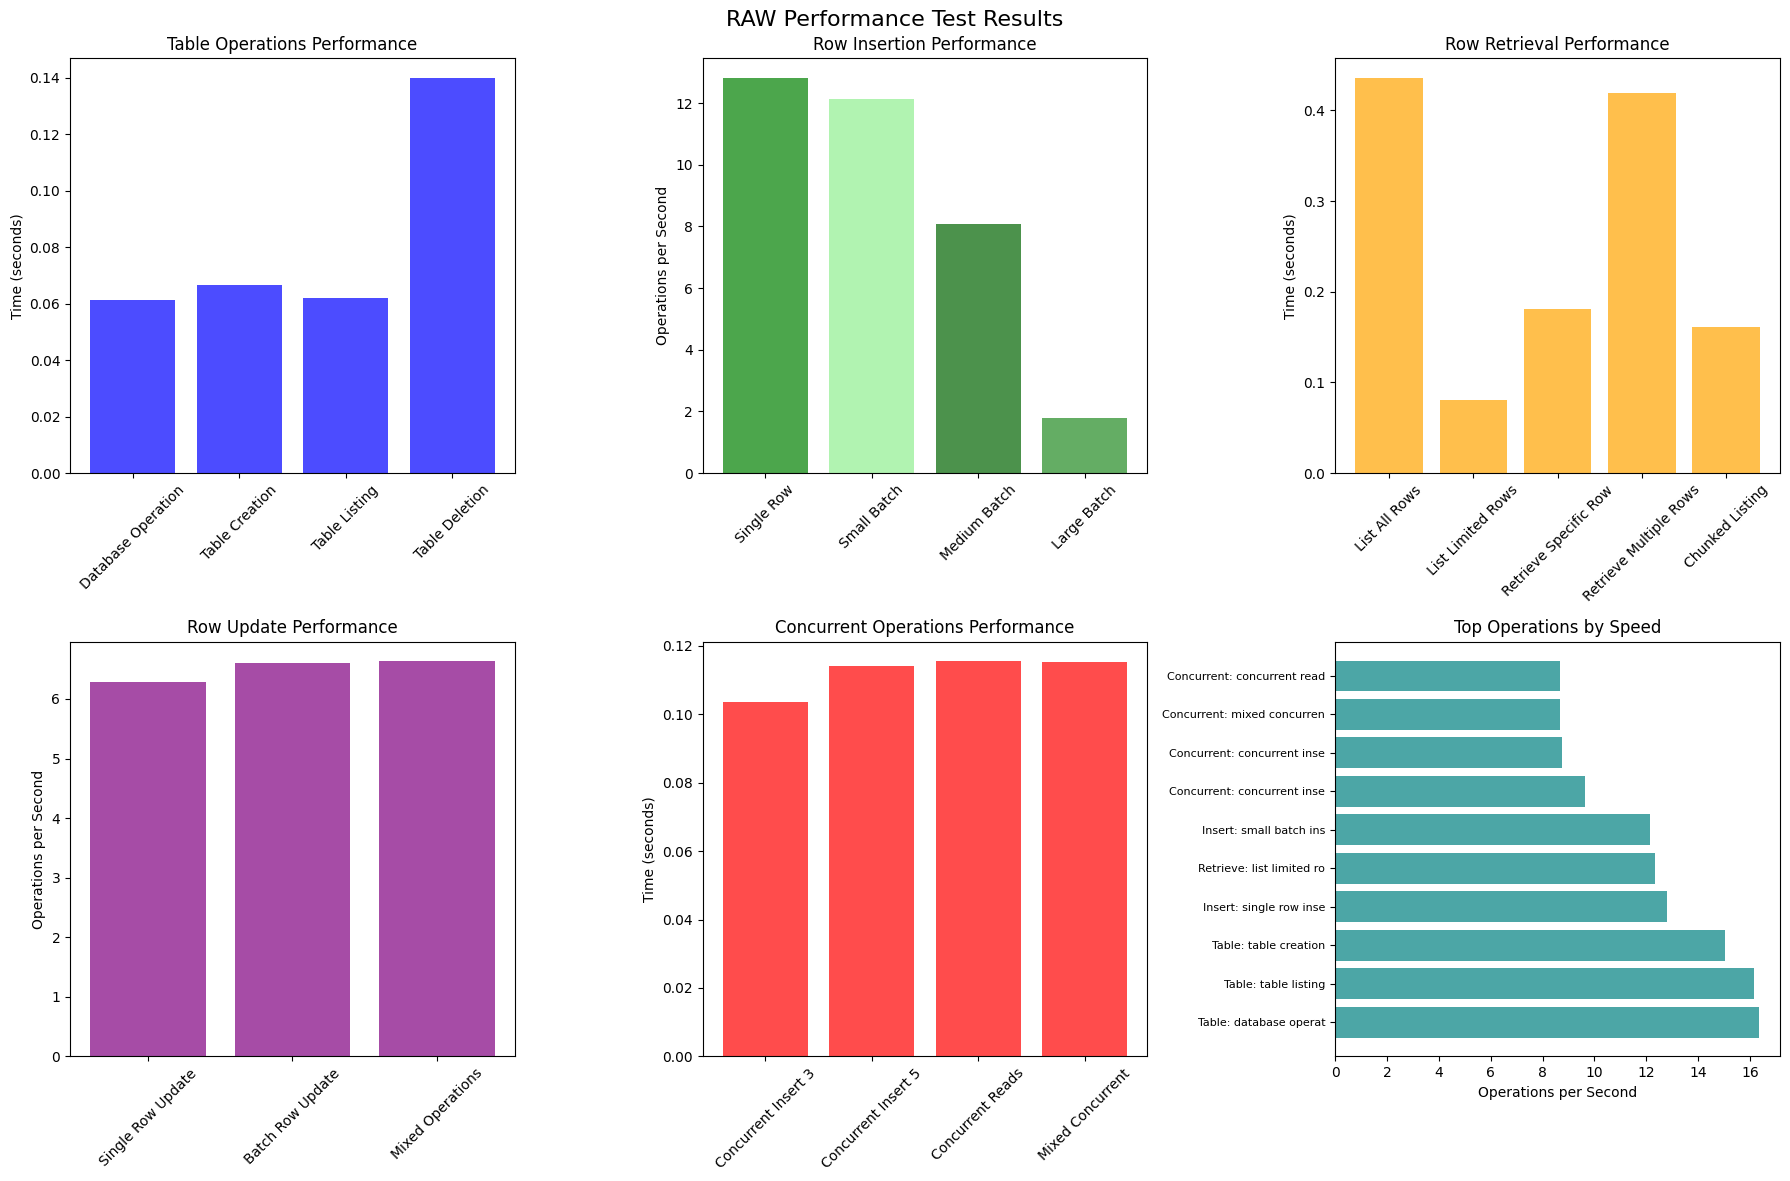


✅ RAW performance testing complete!
💾 Results can be saved using the PerformanceTracker.save_results() method


In [10]:
# Performance Results Summary and Visualization
def summarize_and_visualize_raw_results():
    """Summarize all RAW performance test results and create visualizations."""
    
    print("📈 RAW Performance Test Results Summary")
    print("=" * 60)
    
    # Summarize each test category
    if 'table_results' in globals() and table_results:
        print("\n📊 Table Operations Performance:")
        for test_name, results in table_results.items():
            if results:
                print(f"  {test_name:25} | {results['mean_time']:.4f}s avg | {results['operations_per_second']:.2f} ops/s")
    
    if 'insertion_results' in globals() and insertion_results:
        print("\n📤 Row Insertion Performance:")
        for test_name, results in insertion_results.items():
            if results:
                print(f"  {test_name:25} | {results['mean_time']:.4f}s avg | {results['operations_per_second']:.2f} ops/s")
    
    if 'retrieval_results' in globals() and retrieval_results:
        print("\n📥 Row Retrieval Performance:")
        for test_name, results in retrieval_results.items():
            if results:
                print(f"  {test_name:25} | {results['mean_time']:.4f}s avg | {results['operations_per_second']:.2f} ops/s")
    
    if 'update_results' in globals() and update_results:
        print("\n🔄 Row Update Performance:")
        for test_name, results in update_results.items():
            if results:
                print(f"  {test_name:25} | {results['mean_time']:.4f}s avg | {results['operations_per_second']:.2f} ops/s")
    
    if 'concurrent_results' in globals() and concurrent_results:
        print("\n🔄 Concurrent Operations Performance:")
        for test_name, results in concurrent_results.items():
            if results:
                print(f"  {test_name:25} | {results['mean_time']:.4f}s avg | {results['operations_per_second']:.2f} ops/s")
    
    # Create visualization if matplotlib is available
    if PLOTTING_AVAILABLE:
        try:
            import matplotlib.pyplot as plt
            
            fig, axes = plt.subplots(2, 3, figsize=(18, 12))
            fig.suptitle('RAW Performance Test Results', fontsize=16)
            
            # Plot 1: Table Operations
            if 'table_results' in globals() and table_results:
                ax = axes[0, 0]
                table_tests = [name for name, results in table_results.items() if results]
                table_times = [table_results[name]['mean_time'] for name in table_tests]
                
                if table_tests:
                    ax.bar([name.replace('_', ' ').title() for name in table_tests], 
                           table_times, color='blue', alpha=0.7)
                    ax.set_title('Table Operations Performance')
                    ax.set_ylabel('Time (seconds)')
                    ax.tick_params(axis='x', rotation=45)
            
            # Plot 2: Insertion Performance Comparison
            if 'insertion_results' in globals() and insertion_results:
                ax = axes[0, 1]
                insertion_tests = [name for name, results in insertion_results.items() if results]
                insertion_ops_per_sec = [insertion_results[name]['operations_per_second'] for name in insertion_tests]
                
                if insertion_tests:
                    colors = ['green', 'lightgreen', 'darkgreen', 'forestgreen']
                    ax.bar([name.replace('_insertion', '').replace('_', ' ').title() for name in insertion_tests], 
                           insertion_ops_per_sec, color=colors[:len(insertion_tests)], alpha=0.7)
                    ax.set_title('Row Insertion Performance')
                    ax.set_ylabel('Operations per Second')
                    ax.tick_params(axis='x', rotation=45)
            
            # Plot 3: Retrieval Performance
            if 'retrieval_results' in globals() and retrieval_results:
                ax = axes[0, 2]
                retrieval_tests = [name for name, results in retrieval_results.items() if results]
                retrieval_times = [retrieval_results[name]['mean_time'] for name in retrieval_tests]
                
                if retrieval_tests:
                    ax.bar([name.replace('_', ' ').title() for name in retrieval_tests], 
                           retrieval_times, color='orange', alpha=0.7)
                    ax.set_title('Row Retrieval Performance')
                    ax.set_ylabel('Time (seconds)')
                    ax.tick_params(axis='x', rotation=45)
            
            # Plot 4: Update Performance
            if 'update_results' in globals() and update_results:
                ax = axes[1, 0]
                update_tests = [name for name, results in update_results.items() if results]
                update_ops_per_sec = [update_results[name]['operations_per_second'] for name in update_tests]
                
                if update_tests:
                    ax.bar([name.replace('_', ' ').title() for name in update_tests], 
                           update_ops_per_sec, color='purple', alpha=0.7)
                    ax.set_title('Row Update Performance')
                    ax.set_ylabel('Operations per Second')
                    ax.tick_params(axis='x', rotation=45)
            
            # Plot 5: Concurrent Operations
            if 'concurrent_results' in globals() and concurrent_results:
                ax = axes[1, 1]
                concurrent_tests = [name for name, results in concurrent_results.items() if results]
                concurrent_times = [concurrent_results[name]['mean_time'] for name in concurrent_tests]
                
                if concurrent_tests:
                    ax.bar([name.replace('_', ' ').title() for name in concurrent_tests], 
                           concurrent_times, color='red', alpha=0.7)
                    ax.set_title('Concurrent Operations Performance')
                    ax.set_ylabel('Time (seconds)')
                    ax.tick_params(axis='x', rotation=45)
            
            # Plot 6: Operations per Second Comparison
            ax = axes[1, 2]
            all_ops_per_sec = []
            all_test_names = []
            
            # Collect ops/sec from all tests
            for test_results, category in [
                (globals().get('table_results', {}), 'Table'),
                (globals().get('insertion_results', {}), 'Insert'),
                (globals().get('retrieval_results', {}), 'Retrieve'),
                (globals().get('update_results', {}), 'Update'),
                (globals().get('concurrent_results', {}), 'Concurrent')
            ]:
                for name, results in test_results.items():
                    if results and results['operations_per_second'] > 0:
                        all_ops_per_sec.append(results['operations_per_second'])
                        all_test_names.append(f"{category}: {name.replace('_', ' ')[:15]}")
            
            if all_ops_per_sec:
                # Show top 10 operations by ops/sec
                sorted_data = sorted(zip(all_ops_per_sec, all_test_names), reverse=True)[:10]
                ops_values, test_names = zip(*sorted_data)
                
                ax.barh(range(len(test_names)), ops_values, color='teal', alpha=0.7)
                ax.set_yticks(range(len(test_names)))
                ax.set_yticklabels(test_names, fontsize=8)
                ax.set_title('Top Operations by Speed')
                ax.set_xlabel('Operations per Second')
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"\n📊 Visualization error: {e}")
    else:
        print("\n📊 Install matplotlib for visualizations: pip install matplotlib")
    
    print(f"\n✅ RAW performance testing complete!")
    print(f"💾 Results can be saved using the PerformanceTracker.save_results() method")

# Generate summary
summarize_and_visualize_raw_results()


In [12]:
# Complete RAW Cleanup Function

def cleanup_all_raw_resources():
    """Clean up ALL RAW test resources (database, tables, and rows)."""
    
    if client is None:
        print("❌ Cannot cleanup: Client not available.")
        return
    
    print("🧹 Starting COMPLETE cleanup of all RAW test resources...")
    print("⚠️ This will remove all test tables, rows, and the test database!")
    print("=" * 70)
    
    total_stats = {
        "tables_deleted": 0,
        "rows_deleted": 0, 
        "databases_deleted": 0,
        "errors": 0
    }
    
    try:
        # STEP 1: Clean up rows from all test tables
        print("🔹 STEP 1: Cleaning rows from test tables...")
        
        try:
            # Get list of tables in the test database
            tables = client.raw.tables.list(DATABASE_NAME)
            
            for table in tables:
                try:
                    if table.name is None:
                        print("    Skipping table with None name")
                        continue
                        
                    print(f"    Cleaning rows from table: {table.name}")
                    
                    # Get all rows (note: this might be limited by API)
                    rows = client.raw.rows.list(DATABASE_NAME, table.name, limit=None)
                    
                    if rows:
                        # Delete rows by key
                        row_keys = [row.key for row in rows if row.key is not None]
                        
                        if row_keys:
                            # Delete in batches to avoid API limits
                            batch_size = 100
                            for i in range(0, len(row_keys), batch_size):
                                batch_keys = row_keys[i:i + batch_size]
                                client.raw.rows.delete(DATABASE_NAME, table.name, batch_keys)
                                total_stats["rows_deleted"] += len(batch_keys)
                                print(f"      Deleted {len(batch_keys)} rows from {table.name}")
                    else:
                        print(f"      No rows found in table: {table.name}")
                        
                except Exception as e:
                    table_name_str = table.name if table.name is not None else "Unknown"
                    print(f"    ⚠️ Warning cleaning rows from {table_name_str}: {e}")
                    total_stats["errors"] += 1
                    
        except Exception as e:
            print(f"    ⚠️ Warning listing tables: {e}")
            total_stats["errors"] += 1
        
        # STEP 2: Clean up test tables
        print("\\n🔹 STEP 2: Cleaning test tables...")
        
        try:
            # Get list of tables again (in case some were missed)
            tables = client.raw.tables.list(DATABASE_NAME)
            
            for table in tables:
                try:
                    if table.name is None:
                        print("    Skipping table with None name")
                        continue
                        
                    client.raw.tables.delete(DATABASE_NAME, table.name)
                    total_stats["tables_deleted"] += 1
                    print(f"    ✅ Deleted table: {table.name}")
                except Exception as e:
                    table_name_str = table.name if table.name is not None else "Unknown"
                    print(f"    ⚠️ Warning deleting table {table_name_str}: {e}")
                    total_stats["errors"] += 1
                    
            # Also try to delete known test tables by name
            for table_name in TEST_TABLES:
                try:
                    client.raw.tables.delete(DATABASE_NAME, table_name)
                    total_stats["tables_deleted"] += 1
                    print(f"    ✅ Deleted known test table: {table_name}")
                except Exception as e:
                    # Expected if table doesn't exist
                    pass
                    
        except Exception as e:
            print(f"    ⚠️ Warning in table cleanup: {e}")
            total_stats["errors"] += 1
        
        # STEP 3: Clean up test database
        print("\\n🔹 STEP 3: Cleaning test database...")
        
        try:
            client.raw.databases.delete(DATABASE_NAME)
            total_stats["databases_deleted"] += 1
            print(f"    ✅ Deleted database: {DATABASE_NAME}")
        except Exception as e:
            print(f"    ⚠️ Warning deleting database: {e}")
            total_stats["errors"] += 1
    
    except Exception as e:
        print(f"❌ Error during cleanup: {e}")
        total_stats["errors"] += 1
    
    # Final summary
    print("\\n" + "=" * 70)
    print("✅ RAW CLEANUP FINISHED!")
    print("📊 Summary:")
    print(f"  📁 Rows deleted: {total_stats['rows_deleted']}")
    print(f"  📋 Tables deleted: {total_stats['tables_deleted']}")
    print(f"  🏠 Databases deleted: {total_stats['databases_deleted']}")
    print(f"  ⚠️ Errors encountered: {total_stats['errors']}")
    print("=" * 70)

# Usage Instructions  
print("🧹 RAW CLEANUP FUNCTION READY")
print("=" * 50)
print("")
print("💡 To run complete cleanup:")
print("   1. Uncomment the line below")
print("   2. Run this cell")
print("   3. Check the summary report")
print("")
print("⚠️ WARNING: This removes EVERYTHING!")
print("   - All test rows, tables, and database")
print("   - Cannot be undone")
print("   - Use only when completely done with testing")
print("")
print("🚀 Uncomment to run:")
print("# cleanup_all_raw_resources()")

# Uncomment the line below to run complete cleanup:
cleanup_all_raw_resources()


🧹 RAW CLEANUP FUNCTION READY

💡 To run complete cleanup:
   1. Uncomment the line below
   2. Run this cell
   3. Check the summary report

⚠️ WARNING: This removes EVERYTHING!
   - All test rows, tables, and database
   - Cannot be undone
   - Use only when completely done with testing

🚀 Uncomment to run:
# cleanup_all_raw_resources()
🧹 Starting COMPLETE cleanup of all RAW test resources...
⚠️ This will remove all test tables, rows, and the test database!
🔹 STEP 1: Cleaning rows from test tables...
    Cleaning rows from table: performance_table_1
      Deleted 100 rows from performance_table_1
      Deleted 100 rows from performance_table_1
      Deleted 100 rows from performance_table_1
      Deleted 100 rows from performance_table_1
      Deleted 100 rows from performance_table_1
      Deleted 100 rows from performance_table_1
      Deleted 100 rows from performance_table_1
      Deleted 100 rows from performance_table_1
      Deleted 100 rows from performance_table_1
      Delete